In [ ]:
# !pip install bokeh
# !pip install plotly

In [1]:
import numpy as np
import os
import pandas as pd
import assembly as assembly
import time as time
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy import stats
from bokeh.plotting import figure
from bokeh.io import push_notebook, show, output_notebook
import plotly.graph_objects as go
import pickle
%matplotlib inline
output_notebook()

Loading BokehJS ...

### Sometimes it is "Pre_sleep", sometimes it is "Pre-sleep"

In [125]:
ordered_list = ['Pre_sleep', 'Trial1','Post_Trial1', 'Trial2', 'Post_Trial2', 'Trial3', 
                'Post_Trial3', 'Trial4', 'Post_Trial4', 'Trial5', 'Post_Trial5']
complete_list = ['Pre_sleep', 'Trial1','Post_Trial1', 'Trial2', 'Post_Trial2', 'Trial3', 
                'Post_Trial3', 'Trial4', 'Post_Trial4', 'Trial5', 'PT5_part1', 'PT5_part2', 'PT5_part3', 'PT5_part4']
trial_list = ['Trial1', 'Trial2', 'Trial3', 'Trial4', 'Trial5']

Total_time = 430

In [126]:
def load_actmat(path):
    os.chdir(path)
    neuron_name_file = open("neuron_name_dict.pkl", "rb")
    neuron_name_dict = pickle.load(neuron_name_file)
    actmat_file = open("actmat_dict.pkl", "rb")
    actmat_dict = pickle.load(actmat_file)
    return neuron_name_dict, actmat_dict 

### Change `foler_name` into the correct folder

In [127]:
folder_name = "data_24-25_10_2019_CON_Rn3_SD8"
path = "D:\Internship_Radbound\Cell_Assembly\\" + folder_name
neuron_name_dict, actmat_dict = load_actmat(path)

In [128]:
def combine_all_trial(actmat_dict, ordered_list):
    time_all = np.hstack((actmat_dict[ordered_list[0]], actmat_dict[ordered_list[1]]))
    for item in ordered_list[2:]:
        time_all = np.hstack((time_all, actmat_dict[item]))
    return time_all

In [129]:
def get_actmat_dict_with_split_trial5(actmat_dict):
    trial5_actmat = actmat_dict['Post_Trial5']
    trial5_three_actmat = np.hsplit(trial5_actmat, 4)
#     print(trial5_three_actmat[0])
    actmat_dict['PT5_part1'] = trial5_three_actmat[0]
    actmat_dict['PT5_part2'] = trial5_three_actmat[1]
    actmat_dict['PT5_part3'] = trial5_three_actmat[2]
    actmat_dict['PT5_part4'] = trial5_three_actmat[3]
    actmat_dict.pop('Post_Trial5')
    return actmat_dict

In [130]:
def get_important_neuron(neuron_name_dict, patterns, assembly_group):
    important_neuron = []
    for neuron_index in range(len(patterns[assembly_group])):
        if abs(patterns[assembly_group][neuron_index]) > 2 * np.std(patterns[assembly_group]):
            important_neuron.append(neuron_name_dict[neuron_index] + " with index" + " " + str(neuron_index))
    return important_neuron

In [131]:
def get_important_neuron_by_threshold(neuron_name_dict, patterns, assembly_group, threshold):
    important_neuron = []
    for neuron_index in range(len(patterns[assembly_group])):
        if patterns[assembly_group][neuron_index] > threshold:
            important_neuron.append(neuron_name_dict[neuron_index] + " with index" + " " + str(neuron_index))
    return important_neuron

In [132]:
def plot_actmat_assembly_act(zactmat_variable, assemblyAct_matrix, xrange):
    plt.figure(figsize=(15,6))
    s1 = plt.subplot(211)
    plt.imshow(zactmat_variable[:, :xrange],cmap='Reds',interpolation='nearest',aspect='auto')
    plt.title('z-scored activity matrix')
    plt.ylabel('neuron #')

    plt.subplot(212,sharex=s1)
#     plt.plot(assemblyAct_matrix[:, 0 : xrange].T,linewidth=4)
    for index in range(len(assemblyAct_matrix)):
        label_str = 'index'+ str(index)
        plt.plot(assemblyAct_matrix[index], label = label_str)
    plt.title('assembly activities')
    plt.xlim(0, xrange)
    plt.xlabel('time bin')
    plt.ylabel('strength')
    plt.tight_layout()
    plt.legend()

In [133]:
def show_zactmat(zactmat_matrix):
    TOOLTIPS = [
        ("(x,y)", "($x, $y)")
    ]

    p = figure(plot_width=800, plot_height=400, tooltips=TOOLTIPS)
    p.x_range.range_padding = p.y_range.range_padding = 0
    p.image(image=[zactmat_matrix], x=0, y=0, dw=np.shape(zactmat_matrix)[1], dh=np.shape(zactmat_matrix)[0], palette="Spectral11", level="image")
    p.xaxis.axis_label = 'time bins'
    p.yaxis.axis_label = 'neuron #'
    show(p)
    
def plot_zactmat(zactmat_variable, xrange):
    plt.imshow(zactmat_variable[:, :xrange],cmap='Reds',interpolation='nearest',aspect='auto')
    plt.title('z-scored activity matrix')
    plt.ylabel('neuron #')

In [134]:
def plot_assembly_act(assemblyAct_matrix, xrange):
    plt.figure(figsize=(15,10))
    for index in range(len(assemblyAct_matrix)):
        label_str = 'index'+ str(index)
        plt.plot(assemblyAct_matrix[index], label = label_str)
    plt.title('assembly activities')
    plt.xlim(0, xrange)
    plt.xlabel('time bin')
    plt.ylabel('strength')
    plt.tight_layout()
    plt.legend()
    
def show_assemblyActivity(assemblyAct, ending_time, title_string):
    N = np.shape(assemblyAct)[1]
    x = np.linspace(0, ending_time, N)
    fig = go.Figure()

    for index in range(len(assemblyAct)):
        new_trace = assemblyAct[index]
        fig.add_trace(go.Scatter(x=x, y=new_trace,
                        mode='lines',
                        name='assembly ' + str(index)))

    fig.update_layout(
    title= title_string,
    xaxis_title="time (minutes)",
    yaxis_title="Strength",
    legend_title="assemblies",
)
    fig.write_html(title_string + ".html")
    fig.show()

In [135]:
def get_zscore(actmat):
    silentneurons = np.var(actmat,axis=1)==0
    actmat_ = actmat[~silentneurons,:]
    # z-scoring activity matrix
    zactmat_ = stats.zscore(actmat_,axis=1)
    actmat[~silentneurons, :] = zactmat_
    return actmat

In [136]:
def clean_assemblyAct(assemblyAct, threshold = 5):
    new_assembly = assemblyAct.copy()
    new_assembly[new_assembly <= threshold] = 0
    return new_assembly

In [137]:
def process_pattern(patterns):
    for index in range(len(patterns)):
        if abs(patterns[index].min()) > abs(patterns[index].max()):
            patterns[index] = -patterns[index]
    return patterns

In [138]:
def get_save_important_neuron(patterns):
    important_neuron_dict = {}
    for assembly_index in range(len(patterns)):
        important_neuron_dict[assembly_index] = get_important_neuron(neuron_name_dict, patterns, assembly_index)
    
    important_neuron_file = open("important_neuron_per_assembly.pkl", "wb")
    pickle.dump(important_neuron_dict, important_neuron_file)
    important_neuron_file.close()
    return important_neuron_dict

In [139]:
actmat_all_trials = combine_all_trial(actmat_dict, trial_list)
actmat_all_time = combine_all_trial(actmat_dict, ordered_list)

### Uncomment code below if you haven't run cell assmebly yet

In [140]:
# patterns, significance, zactmat = assembly.runPatterns(actmat_all_trial, method='ica', nullhyp = 'mp', nshu = 1000, percentile = 99, tracywidom = False)
# np.save("patterns", patterns)
# np.save("zactmat", zactmat)

### Get saved configuration of patterns and zactmat used for assembly

In [141]:
patterns = np.load('patterns.npy')
zactmat = np.load('zactmat.npy')
patterns = process_pattern(patterns)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual l

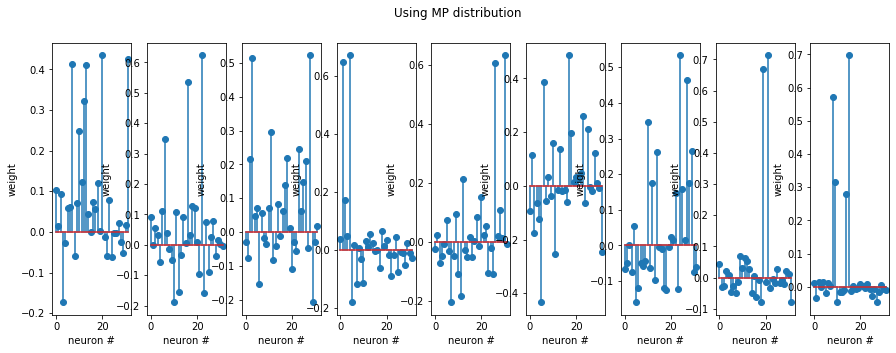

In [142]:
plt.figure(figsize=(15,5))
for (pi, pattern) in enumerate(patterns):
        plt.subplot(1,len(patterns),1+pi)
        plt.stem(pattern)
        plt.xlabel('neuron #')
        plt.ylabel('weight')
plt.suptitle('Using MP distribution')
plt.savefig('cell_assembly_group.png')

In [143]:
important_neuron_dict = get_save_important_neuron(patterns)
important_neuron_dict

{0: ['RGS_PROJECT_RGS14_CON_Rn3_SD8_T9_UID0 with index 7',
  'RGS_PROJECT_RGS14_CON_Rn3_SD8_T9_UID9 with index 12',
  'RGS_PROJECT_RGS14_CON_Rn3_SD8_T9_UID23 with index 13',
  'RGS_PROJECT_RGS14_CON_Rn3_SD8_T11_UID17 with index 20',
  'RGS_PROJECT_RGS14_CON_Rn3_SD8_T13_UID0 with index 31'],
 1: ['RGS_PROJECT_RGS14_CON_Rn3_SD8_T8_UID21 with index 6',
  'RGS_PROJECT_RGS14_CON_Rn3_SD8_T11_UID2 with index 16',
  'RGS_PROJECT_RGS14_CON_Rn3_SD8_T12_UID0 with index 22'],
 2: ['RGS_PROJECT_RGS14_CON_Rn3_SD8_T8_UID11 with index 3',
  'RGS_PROJECT_RGS14_CON_Rn3_SD8_T12_UID55 with index 28'],
 3: ['RGS_PROJECT_RGS14_CON_Rn3_SD8_T8_UID5 with index 1',
  'RGS_PROJECT_RGS14_CON_Rn3_SD8_T8_UID13 with index 4'],
 4: ['RGS_PROJECT_RGS14_CON_Rn3_SD8_T12_UID23 with index 26',
  'RGS_PROJECT_RGS14_CON_Rn3_SD8_T12_UID67 with index 30'],
 5: ['RGS_PROJECT_RGS14_CON_Rn3_SD8_T8_UID15 with index 5',
  'RGS_PROJECT_RGS14_CON_Rn3_SD8_T8_UID21 with index 6',
  'RGS_PROJECT_RGS14_CON_Rn3_SD8_T11_UID4 with index 17

### Get all precessed data:

- zactmat_dict: dict of actmat that has been zscore
- assemblyAct_each_trial_dict: dict with trial period name as key and assemblyAct for each assembly group for each period of time as value
- assemblyAct_mean_dict: dict with trial period name as key and mean of assemblyAct as value (PT5 splitted)

In [144]:
actmat_dict

{'Post_Trial1': array([[1., 2., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]]),
 'Trial2': array([[0., 0., 1., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'Trial1': array([[0., 0., 1., ..., 2., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [2., 0., 0., ..., 0., 0., 0.]]),
 'Trial4': array([[0., 2., 2., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],


In [145]:
zactmat_dict = {}
assemblyAct_each_trial_dict = {}
assemblyAct_mean_dict = {}
actmat_dict_split_PT5 = get_actmat_dict_with_split_trial5(actmat_dict)
for duration_name, each_duration_actmat in actmat_dict_split_PT5.items():
    z_score_actmat = get_zscore(each_duration_actmat)
    zactmat_dict[duration_name] = z_score_actmat
    assembly_act = assembly.computeAssemblyActivity(patterns, each_duration_actmat)
    assembly_act = clean_assemblyAct(assembly_act)
    assemblyAct_each_trial_dict[duration_name] = assembly_act
    mean_each_assembly = assembly_act.mean(axis = 1)
#     time_bins_each_trial = int(len(assembly_act[0]) / (60*(1/0.025)))
    assemblyAct_mean_dict[duration_name] = [[x] for x in mean_each_assembly]

In [146]:
time_all_mean = combine_all_trial(assemblyAct_mean_dict, complete_list)

### Get average strength for all trials/post-trials:

save as png at data folder

data_24-25_10_2019_CON_Rn3_SD8_assemlyAct_strength_mean.png


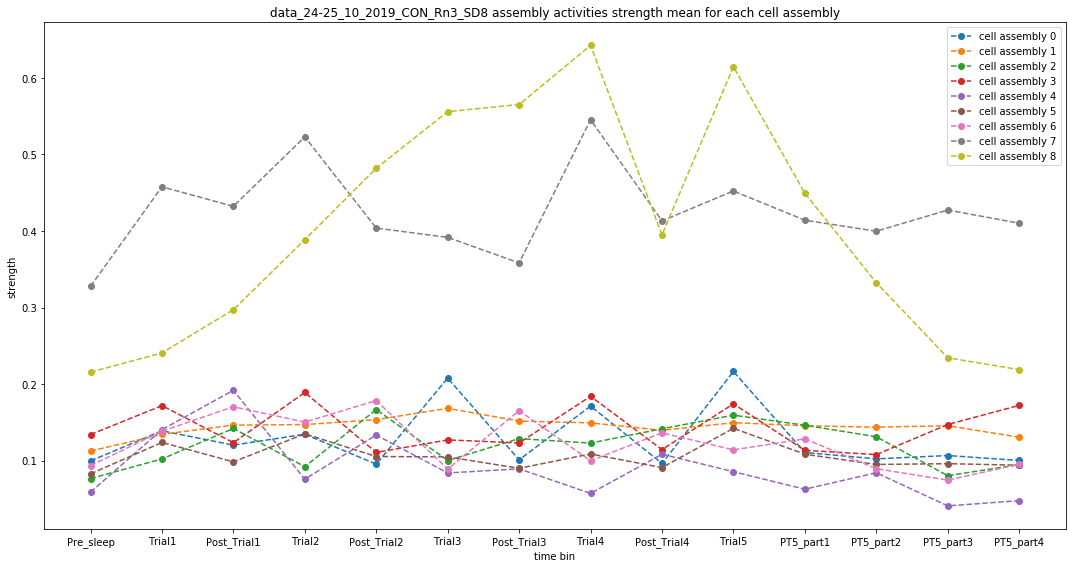

In [148]:
plt.figure(figsize=(15,8))
labels = complete_list
ticks = [x for x in range(len(labels))]
for index in range(len(time_all_mean)):
    label_str = 'cell assembly '+ str(index)
    plt.plot(time_all_mean[index], label = label_str, linestyle='--', marker='o')
plt.title(folder_name + ' assembly activities strength mean for each cell assembly')
plt.xlabel('time bin')
plt.ylabel('strength')
plt.xticks(ticks, labels)
plt.tight_layout()
fig_name = folder_name +'_assemlyAct_strength_mean.png'
print(fig_name)
plt.legend()
plt.savefig(fig_name)

### Below is the plot for cell assembly 

In [ ]:
assemblyAct = assembly.computeAssemblyActivity(patterns, zactmat)
assemblyAct = clean_assemblyAct(assemblyAct)
show_assemblyActivity(assemblyAct, 25, "Assemblies_Activity_in_5_concatenate_trials")

In [ ]:
#For all time
zactmat_all_time = get_zscore(actmat_all_time)
assemblyAct_all_time = assembly.computeAssemblyActivity(patterns, zactmat_all_time)
assemblyAct_all_time = clean_assemblyAct(assemblyAct_all_time)

In [ ]:
show_assemblyActivity(assemblyAct_all_time, 430, "Assemblies Activity in all day")

In [ ]:
#For pre-sleep
zactmat_Presleep = get_zscore(actmat_dict['Pre_sleep'])
assemblyAct_Presleep = assembly.computeAssemblyActivity(patterns, zactmat_Presleep)
assemblyAct_Presleep = clean_assemblyAct(assemblyAct_Presleep)

In [ ]:
show_assemblyActivity(assemblyAct_Presleep, 45, "Assemblies_Activity_in_pre-sleep")

In [ ]:
#For Post_trial_1
zactmat_Post_Trial1 = get_zscore(actmat_dict['Post_Trial1'])
assemblyAct_post_trial1 = assembly.computeAssemblyActivity(patterns, zactmat_Post_Trial1)
assemblyAct_post_trial1 = clean_assemblyAct(assemblyAct_post_trial1)

In [ ]:
show_assemblyActivity(assemblyAct_post_trial1, 45, "Assemblies_Activity_in_post-trial_1")

In [ ]:
#For Post_trial_2
zactmat_Post_Trial2 = get_zscore(actmat_dict['Post_Trial2'])
assemblyAct_post_trial2 = assembly.computeAssemblyActivity(patterns,zactmat_Post_Trial2)
assemblyAct_post_trial2 = clean_assemblyAct(assemblyAct_post_trial2)

In [ ]:
show_assemblyActivity(assemblyAct_post_trial2, 45, "Assemblies_Activity_in_post-trial_2")

In [ ]:
#For Post_trial_3
zactmat_Post_Trial3 = get_zscore(actmat_dict['Post_Trial3'])
assemblyAct_post_trial3 = assembly.computeAssemblyActivity(patterns,zactmat_Post_Trial3)
assemblyAct_post_trial3 = clean_assemblyAct(assemblyAct_post_trial3)

In [ ]:
show_assemblyActivity(assemblyAct_post_trial3, 45, "Assemblies_Activity_in_post-trial_3")

In [ ]:
#For Post_trial_4
zactmat_Post_Trial4 = get_zscore(actmat_dict['Post_Trial4'])
assemblyAct_post_trial4 = assembly.computeAssemblyActivity(patterns, zactmat_Post_Trial4)
assemblyAct_post_trial4 = clean_assemblyAct(assemblyAct_post_trial4)

In [ ]:
show_assemblyActivity(assemblyAct_post_trial4, 45, "Assemblies_Activity_in_post-trial_4")

In [ ]:
#For Post_trial_5
#TODO: Process the first first 45 minutes: 108000 samples
zactmat_Post_Trial5 = get_zscore(actmat_dict['Post_Trial5'][:,:108000])
assemblyAct_post_trial5 = assembly.computeAssemblyActivity(patterns,zactmat_Post_Trial5)
assemblyAct_post_trial5 = clean_assemblyAct(assemblyAct_post_trial5)

In [ ]:
show_assemblyActivity(assemblyAct_post_trial5, 45, "Assemblies_Activity_in_post-trial_5")

In [ ]:
zactmat_Post_Trial5_rest = get_zscore(actmat_dict['Post_Trial5'][:, 108000:])
assemblyAct_post_trial5_rest = assembly.computeAssemblyActivity(patterns,zactmat_Post_Trial5_rest)
assemblyAct_post_trial5_rest = clean_assemblyAct(assemblyAct_post_trial5_rest)

In [ ]:
len(assemblyAct_post_trial5_rest[0])/((1/0.025)*60)

In [ ]:
show_assemblyActivity(assemblyAct_post_trial5_rest, 3*45, "Assemblies_Activity_in_post-trial_5_rest")